In [343]:
# Load usual data libraries
import sys
print(sys.version)
import numpy as np
import nltk
nltk.download('stopwords')
print('numpy version:', np.__version__)
import pandas as pd
print('pandas version:', pd.__version__)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
numpy version: 1.22.4
pandas version: 1.5.3


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [344]:
# Additional libraries
import re
import nltk
from nltk.collocations import *
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud

In [345]:
# Set visualization parameters
print(mpl.style.available)
mpl.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 5) #make the plots bigger, adjust as needed.

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [346]:
# The data (in three csv files) cover all WhiteRights subreddit's comments from January 2015 to January 2016:
%ls wh*.csv

whiterights-FebJun_15.csv  whiterights-Jan_15-16.csv  whiterights-JulDec_15.csv


In [347]:
# Load each file as a pandas dataframe, use header from the first dataframe, set date fields to be transformed:
df1 = pd.read_csv('whiterights-Jan_15-16.csv', dtype = {'created_utc': np.float64, 'retrieved_on': np.float64})

In [348]:
df2 = pd.read_csv('whiterights-FebJun_15.csv', dtype = {'created_utc': np.float64, 'retrieved_on': np.float64}, 
                 usecols = df1.columns)

In [349]:
df3 = pd.read_csv('whiterights-JulDec_15.csv', dtype = {'created_utc': np.float64, 'retrieved_on': np.float64},
                 usecols = df1.columns)

In [350]:
df1.head()

,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class
0,Just remind everyone that whites are a minorit...,NaN,NaN,NaN,HonorableJudgeHolden,Atheist Ethnonationalist,NaN,1.453479e+09,t5_2rjto,t3_425yne,t3_425yne,4,1.454659e+09,0.0,0.0,cz7uspp,WhiteRights,4.0,NaN,natsoc
1,"This is par for the course, as there has been ...",NaN,NaN,NaN,Exterminationist,Christian Identity,NaN,1.452369e+09,t5_2rjto,t3_406o0v,t1_cys0ljz,2,1.454385e+09,0.0,0.0,cys2kvv,WhiteRights,2.0,NaN,edl
2,[deleted],NaN,NaN,NaN,[deleted],NaN,NaN,1.452044e+09,t5_2rjto,t3_3zgnar,t1_cynfs8c,2,1.454306e+09,0.0,0.0,cynih7v,WhiteRights,2.0,NaN,NaN
3,Slavery my arse ..\n\n&gt;Witness the testimon...,NaN,NaN,NaN,TornadoMikeAlley,NaN,NaN,1.453446e+09,t5_2rjto,t3_424fj3,t3_424fj3,1,1.454654e+09,0.0,0.0,cz7j604,WhiteRights,1.0,NaN,NaN
4,"&gt; I may kill myself, but only after all the...",NaN,NaN,NaN,HonorableJudgeHolden,Atheist Ethnonationalist,NaN,1.451668e+09,t5_2rjto,t3_3z0n3y,t1_cyidhph,-1,1.454217e+09,0.0,0.0,cyidjkp,WhiteRights,-1.0,NaN,natsoc


In [351]:
# Check number of rows in each dataframe:
len(df1), len(df2), len(df3)

(2849, 8633, 10224)

In [352]:
# Concatenate dataframes into one with all comments from the subreddit WhiteRights from January 2015 to January 2016:
frames = [df1, df2, df3]
data = pd.concat(frames, ignore_index = True)

In [353]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21706 entries, 0 to 21705
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   body                    21705 non-null  object 
 1   score_hidden            14421 non-null  object 
 2   archived                14421 non-null  object 
 3   name                    14421 non-null  object 
 4   author                  21706 non-null  object 
 5   author_flair_text       3027 non-null   object 
 6   downs                   14421 non-null  float64
 7   created_utc             21706 non-null  float64
 8   subreddit_id            21706 non-null  object 
 9   link_id                 21706 non-null  object 
 10  parent_id               21706 non-null  object 
 11  score                   21706 non-null  int64  
 12  retrieved_on            21565 non-null  float64
 13  controversiality        21705 non-null  float64
 14  gilded                  21705 non-null

In [354]:
# Convert unix time fields into datetime:
data['created_utc'] = pd.to_datetime(data['created_utc'], unit = 's')
data['retrieved_on'] = pd.to_datetime(data['retrieved_on'], unit = 's')

In [355]:
data.dtypes

body                              object
score_hidden                      object
archived                          object
name                              object
author                            object
author_flair_text                 object
downs                            float64
created_utc               datetime64[ns]
subreddit_id                      object
link_id                           object
parent_id                         object
score                              int64
retrieved_on              datetime64[ns]
controversiality                 float64
gilded                           float64
id                                object
subreddit                         object
ups                              float64
distinguished                     object
author_flair_css_class            object
dtype: object

In [356]:
# Visualize data with transformed datetime columns. 
# These columns won't be used in this analysis, but can be very useful later.
data.tail()

,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class
21701,"this will not end well, for them not us. redpi...",False,False,t1_culccl5,grindmonkey,Clerical Fascist,0.0,2015-08-31 01:18:15,t5_2rjto,t3_3iz4qg,t3_3iz4qg,4,2015-09-07 03:44:15,0.0,0.0,culccl5,WhiteRights,4.0,NaN,edl
21702,Hell yes.,False,False,t1_cujl89o,bustedcougar,NaN,0.0,2015-08-29 09:25:10,t5_2rjto,t3_3ir62j,t1_cuj8dra,2,2015-09-06 18:48:21,0.0,0.0,cujl89o,WhiteRights,2.0,NaN,NaN
21703,Why can't we just accept that they're predispo...,False,False,t1_ctvay4j,la-raza-blanca,NaN,0.0,2015-08-07 22:03:53,t5_2rjto,t3_3g2fd2,t3_3g2fd2,1,2015-08-23 16:25:17,0.0,0.0,ctvay4j,WhiteRights,1.0,NaN,NaN
21704,[deleted],False,False,t1_cttzlmq,[deleted],NaN,0.0,2015-08-06 20:16:37,t5_2rjto,t3_3g1ouo,t3_3g1ouo,1,2015-08-23 10:03:10,0.0,0.0,cttzlmq,WhiteRights,1.0,NaN,NaN
21705,White guy went on websites like this shitty su...,False,False,t1_culzuh1,Pardonme23,NaN,0.0,2015-08-31 17:02:07,t5_2rjto,t3_3j0ku2,t1_culor02,0,2015-09-07 06:55:05,0.0,0.0,culzuh1,WhiteRights,0.0,NaN,NaN


In [357]:
# Enter list of stopwords retrieved from the internet to complement that of the NLPTK:
stopwords_list = ['a', 'about', 'above', 'across', 'after', 'afterwards']
stopwords_list += ['again', 'against', 'all', 'almost', 'alone', 'along']
stopwords_list += ['already', 'also', 'although', 'always', 'am', 'among']
stopwords_list += ['amongst', 'amoungst', 'amount', 'amp', 'an', 'and', 'another']
stopwords_list += ['any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere']
stopwords_list += ['are', 'around', 'as', 'at', 'back', 'be', 'became']
stopwords_list += ['because', 'become', 'becomes', 'becoming', 'been']
stopwords_list += ['before', 'beforehand', 'behind', 'being', 'below']
stopwords_list += ['beside', 'besides', 'between', 'beyond', 'bill', 'both']
stopwords_list += ['bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant']
stopwords_list += ['co', 'com', 'computer', 'con', 'could', 'couldnt', 'cry', 'de']
stopwords_list += ['describe', 'detail', 'did', 'do', 'done', 'down', 'due']
stopwords_list += ['during', 'each', 'eg', 'eight', 'either', 'eleven', 'else']
stopwords_list += ['elsewhere', 'empty', 'enough', 'etc', 'even', 'ever']
stopwords_list += ['every', 'everyone', 'everything', 'everywhere', 'except']
stopwords_list += ['few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first']
stopwords_list += ['five', 'for', 'former', 'formerly', 'forty', 'found']
stopwords_list += ['four', 'from', 'front', 'full', 'further', 'get', 'give']
stopwords_list += ['go', 'gt', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her']
stopwords_list += ['here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers']
stopwords_list += ['herself', 'him', 'himself', 'his', 'how', 'however', 'http', 'https']
stopwords_list += ['hundred', 'i', 'ie', 'if', 'in', 'inc', 'indeed']
stopwords_list += ['interest', 'into', 'is', 'it', 'its', 'itself', 'keep']
stopwords_list += ['last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made']
stopwords_list += ['many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine']
stopwords_list += ['more', 'moreover', 'most', 'mostly', 'move', 'much']
stopwords_list += ['must', 'my', 'myself', 'name', 'namely', 'neither', 'never']
stopwords_list += ['nevertheless', 'next', 'nine', 'no', 'nobody', 'none']
stopwords_list += ['noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of']
stopwords_list += ['off', 'often', 'on','once', 'one', 'only', 'onto', 'or']
stopwords_list += ['other', 'others', 'otherwise', 'our', 'ours', 'ourselves']
stopwords_list += ['out', 'over', 'own', 'part', 'per', 'perhaps', 'please']
stopwords_list += ['put', 'r', 'rather', 're', 's', 'same', 'see', 'seem', 'seemed']
stopwords_list += ['seeming', 'seems', 'serious', 'several', 'she', 'should']
stopwords_list += ['show', 'side', 'since', 'sincere', 'six', 'sixty', 'so']
stopwords_list += ['some', 'somehow', 'someone', 'something', 'sometime']
stopwords_list += ['sometimes', 'somewhere', 'still', 'such', 'system', 'take']
stopwords_list += ['ten', 'than', 'that', 'the', 'their', 'them', 'themselves']
stopwords_list += ['then', 'thence', 'there', 'thereafter', 'thereby']
stopwords_list += ['therefore', 'therein', 'thereupon', 'these', 'they']
stopwords_list += ['thick', 'thin', 'third', 'this', 'those', 'though', 'three']
stopwords_list += ['three', 'through', 'throughout', 'thru', 'thus', 'to']
stopwords_list += ['together', 'too', 'top', 'toward', 'towards', 'twelve']
stopwords_list += ['twenty', 'two', 'un', 'under', 'until', 'up', 'upon']
stopwords_list += ['us', 'very', 'via', 'was', 'we', 'well', 'were', 'what']
stopwords_list += ['whatever', 'when', 'whence', 'whenever', 'where']
stopwords_list += ['whereafter', 'whereas', 'whereby', 'wherein', 'whereupon']
stopwords_list += ['wherever', 'whether', 'which', 'while', 'whither', 'who']
stopwords_list += ['whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with']
stopwords_list += ['within', 'without', 'would', 'www', 'yet', 'you', 'your']
stopwords_list += ['yours', 'yourself', 'yourselves']

In [358]:
# Combine lists of stopwords into a set:
nltk_list = stopwords.words('english') #153 items
stop_words = set(nltk_list + stopwords_list) #353 unique items combined

In [359]:
# Create function to clean text data (adapted from https://www.kaggle.com/c/word2vec-nlp-tutorial/):
def clean_content(raw_content):
    """Function to convert a raw content to a string of words
    The input is a single string (one reddit 'body'), and the
    output is a single string (a preprocessed reddit body)"""
    # 1. Remove non-letters (i.e. numbers, punctuation...)        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_content) 
    #
    # 2. Remove HTML tags
    content_text = BeautifulSoup(letters_only).get_text() 
    #
    # 3. Convert to lower case, split into individual words
    words = content_text.lower().split()                             
    #
    # 4. Remove stop words
    meaningful_words = [w for w in words if not w in stop_words]   
    #
    # 5. Join all the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

In [360]:
# Select column 'body' as the text data to work with, remove empty comments
raw_content = data['body'].dropna()
raw_content.head()

0    Just remind everyone that whites are a minorit...
1    This is par for the course, as there has been ...
2                                            [deleted]
3    Slavery my arse ..\n\n&gt;Witness the testimon...
4    &gt; I may kill myself, but only after all the...
Name: body, dtype: object

In [361]:
# Apply function to clean content
content = raw_content.apply(lambda x: clean_content(x))

In [362]:
print(type(content))
content.head()

<class 'pandas.core.series.Series'>


0    remind whites minority california need stop ca...
1    par course influx limp wristed fag apologists ...
2                                              deleted
3    slavery arse witness testimony king dahomey bp...
4    kill nazis purged women poc lgbt people contro...
Name: body, dtype: object

In [363]:
# Create function to merge all rows of a series into one string (to be used to create a word cloud):
def create_string(series):
    """Function to create one string from the text content of a pandas series """
    wordstring = ''
    for row in series:
        wordstring += ' ' + row
    return wordstring

In [364]:
words = create_string(content) #merge each line (content) into one string

In [365]:
# Check result (last 200 characters)
words[-200:]

'random people based race evidence gated black people prior crime black guy disgruntled employer killed people knew personal vendetta legally hate crime expect able tell difference echo chamber educate'

In [366]:
# Generate a word cloud by taking relative word frequencies into account, lower max_font_size:
wordcloud = WordCloud(max_font_size = 40, relative_scaling = 0.5).generate(words)

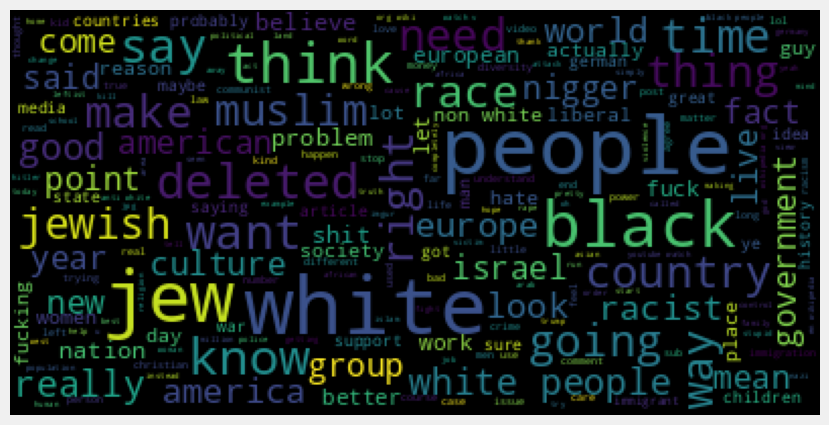

In [367]:
# Plot via matplotlib:
fig = plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [368]:
# Save word cloud image
#fig.savefig('wordcloud.pdf', bbox_inches='tight')

In [369]:
# Create a list of tokens (words)
word_list = words.split()

In [370]:
# Show number of tokens in the dataset as well as number of unique tokens:
len(word_list), len(set(word_list))

(410084, 32210)

In [371]:
# Count the frequency of each word using the collections library:
wordcount = Counter(word_list) #expects list of tokens, not one string

In [372]:
# Visualize the top 10 words with the highest counts in the corpus:
# top10=pd.Series(dict(wordcount)).order(ascending = False)[:10]
top10 = pd.Series(wordcount).sort_values(ascending=False).head(10)
# print(top10)

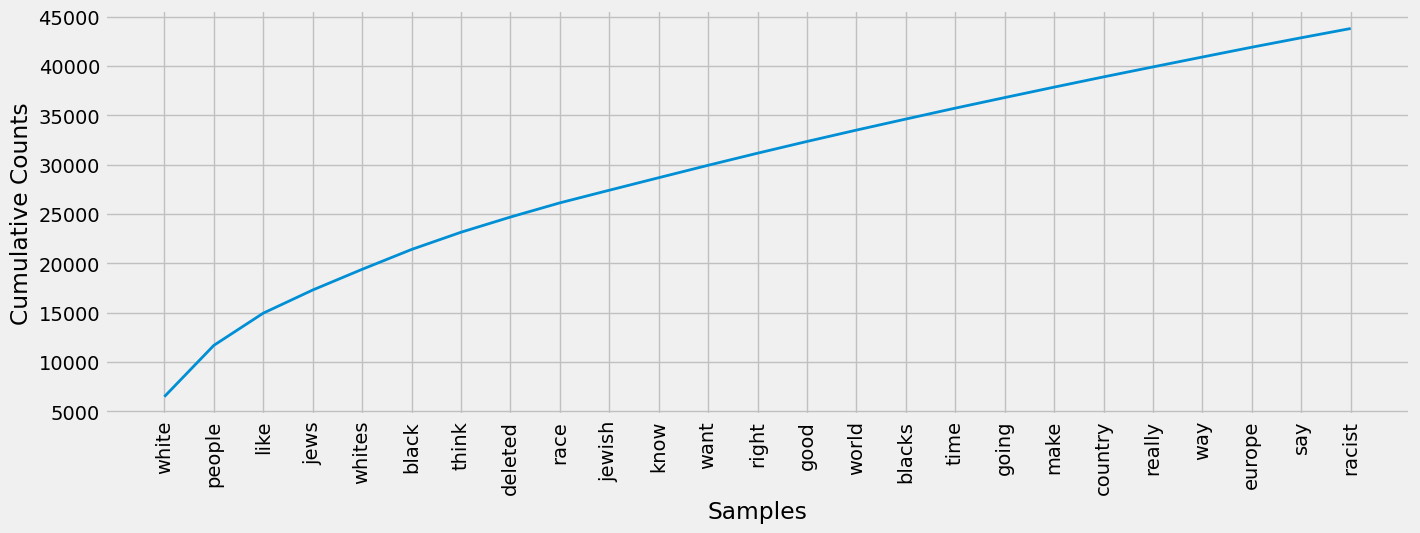

<Axes: xlabel='Samples', ylabel='Cumulative Counts'>

In [373]:
# Plot cumulative frequency distribution using the NLTK:
nltk.FreqDist(word_list).plot(25, cumulative=True)

In [374]:
# Analyzing bigrams: here are the first 10 bigrams in the text:
list(nltk.bigrams(word_list))[:10]

[('remind', 'whites'),
 ('whites', 'minority'),
 ('minority', 'california'),
 ('california', 'need'),
 ('need', 'stop'),
 ('stop', 'calling'),
 ('calling', 'non'),
 ('non', 'minorities'),
 ('minorities', 'minorities'),
 ('minorities', 'par')]

In [375]:
# We want to find bigrams that occur more often than we would expect based on the frequency of the individual words. 
# The collocations function does this for us:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(word_list)
finder.apply_freq_filter(3) #ignores any bigram that occurs less than 3 times in the text
top50_bigrams = finder.nbest(bigram_measures.pmi, 50) #top 50 bigrams

In [376]:
# Visualize top 50 bigrams as a dataframe:
bigram_df = pd.DataFrame(top50_bigrams, columns = ['word_1', 'word_2']) 
bigram_df

,word_1,word_2
0,aboda,zara
1,agnes,selsing
2,banu,qurayza
3,benklassen,thewhiteman
4,bix,nood
5,caleb,shumaker
6,clint,eastwood
7,convertstometric,xhk
8,fiddle,jshell
9,grassy,knoll


In [377]:
# Save top 50 bigrams
#bigram_df.to_csv('Top50Bigrams.csv')

In [378]:
%ls off*.csv

offensive_words_rev.csv


In [379]:
#Load list of offensive terms (collected and cleaned from four different internet sources):
offensive = pd.read_csv('offensive_words_rev.csv')
offensive.head()

,term
0,cunt
1,punt
2,abbo
3,abo
4,abortion


In [380]:
offensive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311 entries, 0 to 2310
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   term    2311 non-null   object
dtypes: object(1)
memory usage: 18.2+ KB


In [381]:
#Remove duplicates and make all words lower case
offensive.term = offensive.term.apply(lambda x: x.lower()) #set all words to lower case
offensive.drop_duplicates(inplace = True)
len(offensive)

2067

In [382]:
#Reindex series
offensive.reset_index(level=0, inplace=True)
offensive = offensive['term']
type(offensive)

pandas.core.series.Series

In [383]:
pd.DataFrame(offensive).tail()

,term
2062,zigabo
2063,zipperhead
2064,zit
2065,face
2066,zubb


In [384]:
def offensive_count(token):
    """
    Function that takes a list of tokens and returns 
    a list of tuples counting membership (yes, no) in the
    list of offensive words (token, membership)
    """
    if token in offensive.tolist():
        result = (token, 1)
    else:
        result = (token, 0)
    return result

In [385]:
# Apply the offensive count function to the list of tokens, group results and visualize in a dataframe:
offensive_map = pd.DataFrame(map(offensive_count, word_list), columns = ['token', 'count']).groupby('token').sum()

In [386]:
# Reset the dataframe's index (always be sure whether you want to do this in place!)
offensive_map.reset_index(level = 0, inplace = True)
offensive_map.head()

,token,count
0,aa,0
1,aaa,0
2,aaaaaaaa,0
3,aaaaaaaaali,0
4,aaaaaaaaapy,0


In [387]:
# Show most frequent offensive words (count greater than 200):
offensive_map[offensive_map['count'] > 200] #40 tokens

,token,count
547,africa,455
549,african,262
954,american,636
1629,asian,205
2912,black,2012
2948,blacks,1120
3742,bullshit,214
5409,communist,257
6308,crime,570
9536,ethnic,372


In [388]:
# Create a function to return a simple "offensiveness score (%)" from a reddit comment:
def offensive_score(comment):
    """
    Function that takes a comment (string of words), 
    counts membership of each word (yes or no) in the list 
    of offensive words (word, membership), and returns the
    sum of words in the offensive list divided by the total
    number of words in the comment.
    """
    results = []
    for token in comment.split():
        if token in offensive.tolist():
            results.append((token, 1))
        else:
            results.append((token, 0))
    
    return float(sum([item[1] for item in results])) / len(results)

In [389]:
#Example of comment made up entirely of words in the stopwords list:
print(data.body[137])
content[137]

I did my part.  Did you?


''

In [390]:
#Some comments were processed so that they resulted in no content, thus causing division by zero
print(clean_content(data.body[137]))
print(len(content))
len(content[content == '']) #109 empty comments after processing


21705


109

In [391]:
# Apply scoring function to text content
text_series = content[content != ''] #disregard empty values (no content after processing comment)
scored_content = text_series.apply(lambda x: offensive_score(x))
scored_content.head() #pandas series with scores

0    0.200000
1    0.066667
2    0.000000
3    0.039801
4    0.051724
Name: body, dtype: float64

In [392]:
# Create a dataframe  and add column to show the offensiveness score for each comment (row):
df_scored = pd.DataFrame(text_series)
df_scored['score'] = scored_content
df_scored.head()

,body,score
0,remind whites minority california need stop ca...,0.200000
1,par course influx limp wristed fag apologists ...,0.066667
2,deleted,0.000000
3,slavery arse witness testimony king dahomey bp...,0.039801
4,kill nazis purged women poc lgbt people contro...,0.051724


In [393]:
df_scored.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21705
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   body    21596 non-null  object 
 1   score   21596 non-null  float64
dtypes: float64(1), object(1)
memory usage: 506.2+ KB


In [394]:
# Show all commenst with score greater than 70% but below 100%:
df_scored[(df_scored['score'] > 0.7) & (df_scored['score'] < 1)]

,body,score
1758,slave god exist slave world shit fight,0.714286
3347,like israel fight fucking towelhead terrorists...,0.727273
9042,cracker mad cracker mad lol,0.800000
9950,blacks racist whites whites attention,0.800000
14949,whites racist soon shit,0.750000
15024,whites chanting blacks fucking sick,0.800000
17371,fuck niggers jew tells,0.750000
18776,dumb bitch probably deserved whites fucking suck,0.714286
20511,shoot niggers let rot,0.750000
21487,black dick sucking asshole,0.750000


In [395]:
# Read raw text content of some of the above comments:
data.body[19235] 

'Are you defending these murders ?'

In [396]:
data.body[10409]

'I totally agree. We\'re going to witness the formation a "coloured" class much like South Africa. Except our "coloureds" will be an elite consisting of 3rd+ generation Indians, Pakistanis, other Asians and the offspring of whites who intermarry therewith. \n\nWe are going to have this quasi-elite outgroup complaining about white racism, but it\'s going to be sort of weird and awkward because one of their principal grievances will be their inability to attract white women (white men essentially don\'t care about race). This is already evident in people like [Reihan Salam](http://www.slate.com/articles/news_and_politics/politics/2014/04/okcupid_and_race_is_it_racist_to_date_only_people_of_your_own_race.html) and Elliot Rodger, but it\'s going to get much worse as this class of people become progressively more alienated from their ancestral culture. Race mixing propaganda will go through the roof I suppose.\n\nI don\'t know what you think, but I have come to believe that nearly all anti-

In [397]:
# Show the 20 most offensive scored comments (less than 100%):
# df_scored[df_scored['score'] < 1].sort_values(columns='score', axis=0, ascending=False).head(20)
df_scored[df_scored['score'] < 1].sort_values(by='score', axis=0, ascending=False).head(20)

,body,score
15024,whites chanting blacks fucking sick,0.800000
9042,cracker mad cracker mad lol,0.800000
9950,blacks racist whites whites attention,0.800000
17371,fuck niggers jew tells,0.750000
21487,black dick sucking asshole,0.750000
20511,shoot niggers let rot,0.750000
14949,whites racist soon shit,0.750000
3347,like israel fight fucking towelhead terrorists...,0.727273
1758,slave god exist slave world shit fight,0.714286
18776,dumb bitch probably deserved whites fucking suck,0.714286


In [398]:
data.loc[15483]

body                      Um there several that are in French that show ...
score_hidden                                                            NaN
archived                                                                NaN
name                                                                    NaN
author                                                   Nationalistreturns
author_flair_text                                                       NaN
downs                                                                   NaN
created_utc                                             2015-12-16 16:38:32
subreddit_id                                                       t5_2rjto
link_id                                                           t3_3wqp4l
parent_id                                                        t1_cxyiciv
score                                                                     1
retrieved_on                                            2016-01-01 20:20:04
controversia

In [399]:
# A snapshot of the complete data of the worst (20 most offensive comments):
i = df_scored[(df_scored['score'] > 0.7) & (df_scored['score'] < 1)].index
data.loc[i]

,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class
1758,I'm not a slave to a god that doesn't exist.\n...,False,False,t1_cnvnrha,SluttyGoyToy,NaN,0.0,2015-01-21 03:04:18,t5_2rjto,t3_2t4j7i,t3_2t4j7i,1,2015-02-21 04:30:30,0.0,0.0,cnvnrha,WhiteRights,1.0,NaN,NaN
3347,What if I like Israel because they fight the f...,False,False,t1_cp74bg6,Pardonme23,NaN,0.0,2015-03-07 08:27:09,t5_2rjto,t3_2y58h7,t1_cp6n3d5,-1,2015-03-29 10:52:18,0.0,0.0,cp74bg6,WhiteRights,-1.0,NaN,NaN
9042,cracker mad cracker mad lol,False,False,t1_cs07w99,jvvsh,NaN,0.0,2015-06-09 03:32:26,t5_2rjto,t3_3944k9,t1_cs07tfy,-1,2015-07-14 02:19:07,0.0,0.0,cs07w99,WhiteRights,-1.0,NaN,NaN
9950,Blacks are more racist than whites but whites ...,False,False,t1_cqpuxna,shamwoahh,NaN,0.0,2015-04-27 02:48:42,t5_2rjto,t3_33z4ml,t1_cqpur22,7,2015-05-26 07:06:23,0.0,0.0,cqpuxna,WhiteRights,7.0,NaN,NaN
14949,Whites who aren't racist yet soon will be if t...,NaN,NaN,NaN,CylonChick8,NaN,NaN,2015-11-29 16:57:37,t5_2rjto,t3_3ufras,t3_3ufras,1,2015-12-14 13:58:55,0.0,0.0,cxguzgt,WhiteRights,1.0,NaN,NaN
15024,They're more whites chanting then blacks. Fuck...,NaN,NaN,NaN,PSYOP14EE,NaN,NaN,2015-11-16 15:46:33,t5_2rjto,t3_3t00by,t3_3t00by,5,2015-12-11 11:34:52,0.0,0.0,cx24vjk,WhiteRights,5.0,NaN,NaN
17371,Fuck these niggers. They will do whatever the ...,NaN,NaN,NaN,no-na-ha,NaN,NaN,2015-12-27 19:26:27,t5_2rjto,t3_3yf9sm,t3_3yf9sm,3,2016-01-04 05:08:50,0.0,0.0,cycyw0z,WhiteRights,3.0,NaN,NaN
18776,That dumb bitch probably deserved it.\n\nWhite...,False,False,t1_ctp5smn,MilotisMelon,NaN,0.0,2015-08-02 20:08:12,t5_2rjto,t3_3fihcf,t3_3fihcf,-19,2015-08-22 10:54:07,0.0,0.0,ctp5smn,WhiteRights,-19.0,NaN,NaN
20511,just shoot the niggers and let them rot.\n,False,False,t1_cuauja6,Girlsbumsarefun,NaN,0.0,2015-08-21 17:04:15,t5_2rjto,t3_3hu9jl,t3_3hu9jl,7,2015-09-04 17:26:33,0.0,0.0,cuauja6,WhiteRights,7.0,NaN,NaN
21487,So just a black dick sucking asshole?,False,False,t1_ctszoux,Maximus_dinduicus,NaN,0.0,2015-08-06 00:09:15,t5_2rjto,t3_3fx2uk,t1_ctsyd3e,2,2015-08-23 05:15:42,0.0,0.0,ctszoux,WhiteRights,2.0,NaN,NaN
